In [17]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlciic import functions

def beforeModel(df: pd.DataFrame, drop_columns: list,label: str, one_hot_encoder = True, label_encoder = True, valid_indices = False, test_size = 0.2, standard_scaler = True, smote = True, random_state = 1):
    """
    Function to preprocess data before model training.

    Parameters:
    df (pandas.DataFrame): Input dataframe.
    drop_columns (list): List of column names to drop.
    label (str): Label column name.
    one_hot_encoder (bool): Whether to use one-hot encoding. Defaults to True.
    label_encoder (bool): Whether to use label encoding. Defaults to True.
    valid_indices (bool): Whether to use validation set. Defaults to False.
    test_size (float): Size of the test set. Defaults to 0.2.
    standard_scaler (bool): Whether to use standard scaler. Defaults to True.
    smote (bool): Whether to use SMOTE for oversampling. Defaults to True.
    random_state (int): Random state for reproducibility. Defaults to 1.

    Returns:
    X_train (numpy.ndarray): Training features.
    y_train (numpy.ndarray): Training labels.
    X_test (numpy.ndarray): Test features.
    y_test (numpy.ndarray): Test labels.
    X_valid (numpy.ndarray): Validation features if valid_indices=True.
    y_valid (numpy.ndarray): Validation labels if valid_indices=True.
    le (LabelEncoder): Label encoder object.
    """
    
    # Check input types
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame.")
    if not isinstance(drop_columns, list):
        raise TypeError("Input 'drop_columns' must be a list of column names to drop.")
    
    functions.display_information_dataframe(df,showCategoricals = True, showDetailsOnCategorical = True, showFullDetails = True)
    
    df.drop(drop_columns, axis=1, inplace=True)
    df.dropna(axis=0, how='any', inplace=True)
    df.drop_duplicates(subset=None, keep="first", inplace=True)
    df = shuffle(df)
    
    categorical_columns = []
    for col in df.columns[df.dtypes == object]:
        if col != label:
            categorical_columns.append(col)
    features = [ col for col in df.columns if col not in [label]]
    
    if one_hot_encoder:
        df, colunas_one_hot = functions.categorical_get_dummies(df, categorical_columns)
        features = [ col for col in df.columns if col not in [label]] 
    
    if label_encoder:
        df, le = functions.encode_labels(df, label)
    
    n_total = len(df)
    train_val_indices, test_indices = train_test_split(range(n_total), test_size=test_size, random_state=random_state)

    if valid_indices:
        train_indices, valid_indices = train_test_split(train_val_indices, test_size=0.25, random_state=random_state) # 0.25 x 0.8 = 0.2
        X_valid = df[features].values[valid_indices]
        y_valid = df[label].values[valid_indices]
        
        X_train = df[features].values[train_indices]
        y_train = df[label].values[train_indices]
    else:
        X_train = df[features].values[train_val_indices]
        y_train = df[label].values[train_val_indices]
        

    X_test = df[features].values[test_indices]
    y_test = df[label].values[test_indices]
    
    if standard_scaler:
        standScaler = StandardScaler()
        model_norm = standScaler.fit(X_train)

        X_train = model_norm.transform(X_train)
        X_test = model_norm.transform(X_test)
        if valid_indices:
            X_valid = model_norm.transform(X_valid)

    if smote:
        from imblearn.over_sampling import SMOTE
        sm = SMOTE(random_state=random_state,n_jobs=-1)
        X_train, y_train = sm.fit_resample(X_train, y_train)
    
    results = (X_train, y_train, X_test, y_test)
    if 'X_valid' in locals():
        results += (X_valid, y_valid)
    if 'le' in locals():
        results += (le,)

    return results
    

In [20]:
df = pd.read_csv('dataset.csv', low_memory=False)

drop_columns = ["frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4","arp.dst.proto_ipv4", 
         "http.file_data","http.request.full_uri","icmp.transmit_timestamp",
         "http.request.uri.query", "tcp.options","tcp.payload","tcp.srcport",
         "tcp.dstport", "udp.port", "mqtt.msg"]

from mlciic import models
X_train, y_train, X_test, y_test, X_valid, y_valid, le = models.beforeModel(df = df,drop_columns = drop_columns, label = "Attack_type", one_hot_encoder = True, label_encoder = True, valid_indices = True, test_size = 0.2, standard_scaler = True, smote = True, random_state = 1)

  

---
Lines: 14400
Columns: 63 
Missing value or NaN: 0
---
Categorical columns: 
['frame.time', 'ip.src_host', 'ip.dst_host', 'arp.dst.proto_ipv4', 'arp.src.proto_ipv4', 'http.file_data', 'http.request.uri.query', 'http.request.method', 'http.referer', 'http.request.full_uri', 'http.request.version', 'tcp.options', 'tcp.payload', 'tcp.srcport', 'dns.qry.name.len', 'mqtt.conack.flags', 'mqtt.msg', 'mqtt.protoname', 'mqtt.topic', 'Attack_type']

--- Details for categorical columns ---
frame.time: 
[' 2021 19:52:48.845952000 ' ' 2021 20:17:04.185980000 '
 ' 2021 20:35:28.516430000 ' ' 2021 17:29:23.754024000 '
 ' 2021 19:42:25.745850000 ' ' 2021 17:25:24.201498000 '
 ' 2021 01:50:53.836410000 ' ' 2021 18:10:26.406263000 '
 ' 2021 18:59:56.621812000 ' ' 2021 20:35:26.094938000 '
 ' 2021 19:54:04.851113000 ' ' 2021 18:27:12.673522000 '
 ' 2021 20:29:37.028754000 ' ' 2021 19:43:43.029645000 '
 ' 2021 18:55:41.580851000 ' ' 2021 17:36:53.007157000 '
 ' 2021 01:54:40.572112000 ' ' 2021 17:05:50

,Data Type,Column Name,Unique Values
0,object,frame.time,"[ 2021 19:52:48.845952000 , 2021 20:17:04.185..."
1,object,ip.src_host,"[192.168.0.170, 192.168.0.128, 0, 240.217.191...."
2,object,ip.dst_host,"[192.168.0.128, 192.168.0.170, 0, 240.217.191...."
3,object,arp.dst.proto_ipv4,"[0, 192.168.0.152, 192.168.0.128, 192.168.0.14..."
4,float64,arp.opcode,"[0.0, 1.0, 2.0]"
5,float64,arp.hw.size,"[0.0, 6.0]"
6,object,arp.src.proto_ipv4,"[0, 192.168.0.152, 0.0, 192.168.0.1, 192.168.0..."
7,float64,icmp.checksum,"[0.0, 39342.0, 5911.0, 42797.0, 48731.0, 20330..."
8,float64,icmp.seq_le,"[0.0, 28440.0, 13018.0, 4244.0, 53225.0, 28444..."
9,float64,icmp.transmit_timestamp,"[0.0, 77200070.0, 76810629.0, 77131332.0, 7701..."


/Users/melicias/.local/lib/python3.7/site-packages/imblearn/over_sampling/_smote/base.py:340: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  FutureWarning,


              precision    recall  f1-score   support

           0       0.92      0.96      0.94       203
           1       0.83      0.82      0.83       227
           2       1.00      0.99      1.00       200
           3       0.99      1.00      0.99       198
           4       1.00      1.00      1.00       202
           5       0.85      0.82      0.84       195
           6       1.00      1.00      1.00        63
           7       1.00      1.00      1.00       200
           8       0.77      0.83      0.80       189
           9       0.85      0.86      0.85       181
          10       0.93      0.90      0.92       176
          11       0.82      0.81      0.81       176
          12       0.86      0.80      0.83       170
          13       0.93      0.92      0.93       197
          14       0.83      0.85      0.84       202

    accuracy                           0.90      2779
   macro avg       0.91      0.90      0.90      2779
weighted avg       0.90   

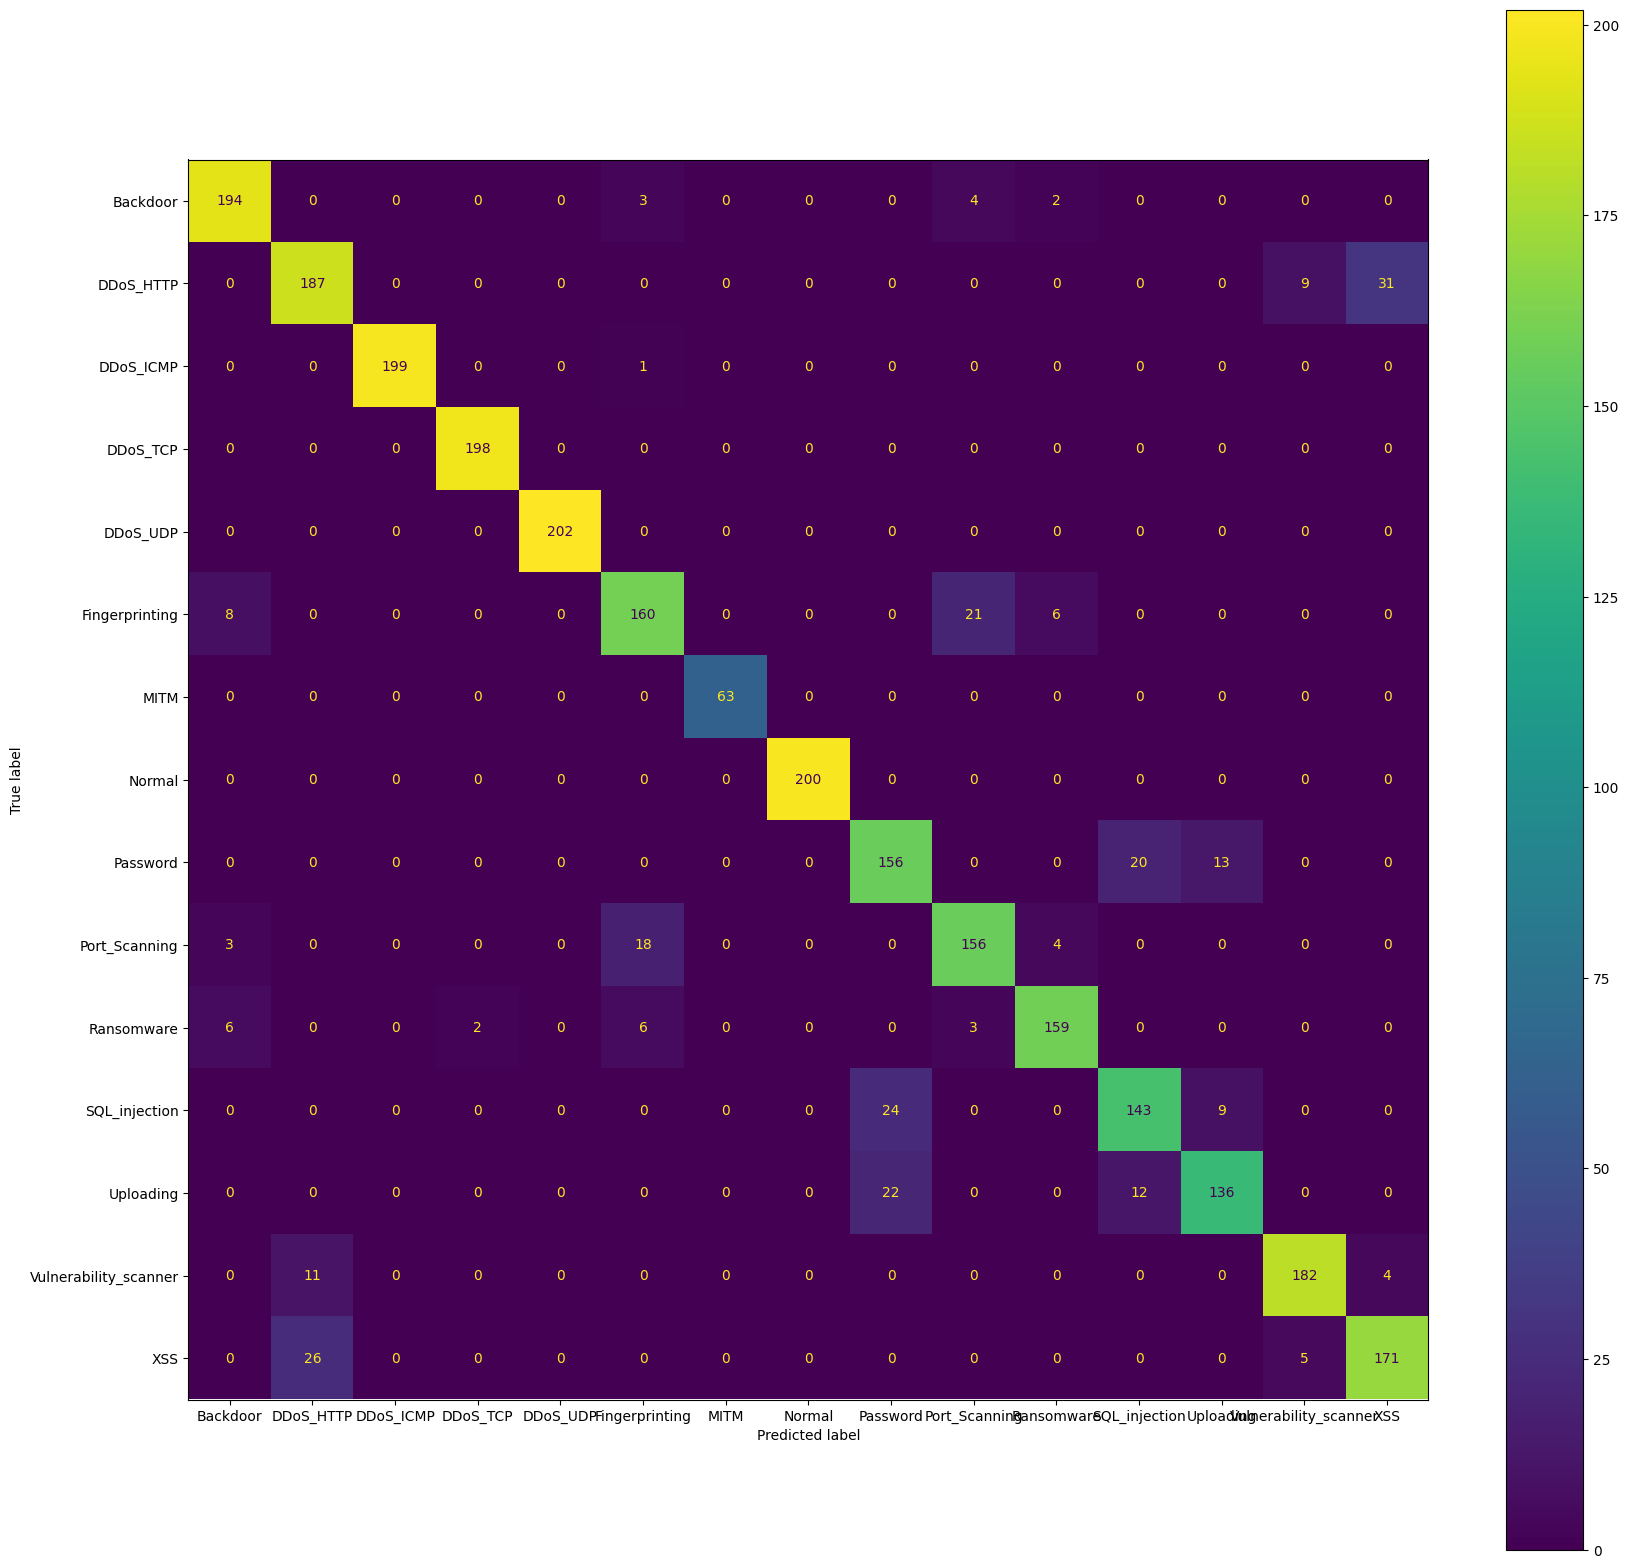

NameError: name 'calcula_metricas' is not defined